# Analyse qPCR data for changes in biomass in preterm infants

In [2]:
import plotnine as pn
import pandas as pd
import numpy as np
from scipy.stats import sem

%matplotlib notebook

## Examine the data with metabolomically informed antibiotics

In [124]:
root_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/"
md = pd.read_csv(root_dir + "intermediate_data/20200611_filtered_16S_metadata.tsv", sep='\t', index_col=0)

st2_dat = pd.read_csv(root_dir + "raw_data/combined_qpcr_data.txt", sep='\t',
                      low_memory=False,na_values=['not collected','not applicable','indeterminable'])

st2_dat = st2_dat[st2_dat.columns[~st2_dat.columns.str.contains('units')]]
st2_dat = st2_dat[st2_dat.columns[~st2_dat.columns.str.contains('raw')]]
st2_dat = st2_dat[st2_dat.columns[~st2_dat.columns.str.contains('qpcr')]]
st2_dat['frac_bact'] = st2_dat['bacterial_dna_concentration_bg_corrected']/(st2_dat['bacterial_dna_concentration_bg_corrected']+st2_dat['human_dna_concentration_bg_corrected'])
st2_dat['percent_qubit'] = st2_dat['bacterial_dna_concentration_bg_corrected']/(st2_dat['qubit_dna_concentration'])
#remove outliers 
#st2_dat = st2_dat[st2_dat['percent_qubit'].between(st2_dat['percent_qubit'].quantile(0.003), st2_dat['percent_qubit'].quantile(0.997))]
st2_dat['percent_qubit'] = st2_dat['percent_qubit'].apply(lambda x: 1.0 if x > 1.0 else x) # dodgy at best, just to view
st2_dat = st2_dat[st2_dat.columns[~st2_dat.columns.str.contains('qubit_dna')]]
st2_dat = st2_dat.melt(id_vars='sample_name').set_index('sample_name')
st2_dat = st2_dat.merge(md.loc[:,["sample_type","abx_any_source","qiita_study_id","study_delivery_mode","age"]], right_index=True, left_index=True)
st2_dat['value'] =st2_dat['value'].apply(lambda x: pd.to_numeric(x,errors='coerce'))
plot_dat = st2_dat.groupby(["study_delivery_mode","sample_type","abx_any_source","age","variable"]).agg({"value":["mean",sem,"count"]}).dropna()
plot_dat = plot_dat.reset_index()
plot_dat.columns = ["study_delivery_mode","sample_type","abx_any_source","age","variable","avg","err","n"]
plot_dat["err_min"] = plot_dat.apply(axis=1, func=lambda row: row.avg - row.err )
plot_dat["err_max"] = plot_dat.apply(axis=1, func=lambda row: row.avg + row.err )
plot_dat

/home/adswafford/.conda/envs/qiime2-2020.11/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/adswafford/.conda/envs/qiime2-2020.11/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars


,study_delivery_mode,sample_type,abx_any_source,age,variable,avg,err,n,err_min,err_max
0,LP-C-section,Oral,0,0.0,bacterial_dna_concentration_bg_corrected,0.000000,0.000000,2,0.000000,0.000000
1,LP-C-section,Oral,0,0.0,human_dna_concentration_bg_corrected,0.000110,0.000110,2,0.000000,0.000219
2,LP-C-section,Oral,0,0.0,percent_qubit,0.000000,0.000000,2,0.000000,0.000000
3,LP-C-section,Oral,0,1.0,bacterial_dna_concentration_bg_corrected,0.000000,0.000000,3,0.000000,0.000000
4,LP-C-section,Oral,0,1.0,frac_bact,0.000000,0.000000,3,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
294,VLBW-C-section,Stool,1,4.0,bacterial_dna_concentration_bg_corrected,0.003037,0.002063,13,0.000974,0.005100
295,VLBW-C-section,Stool,1,4.0,human_dna_concentration_bg_corrected,0.066931,0.064759,13,0.002172,0.131689
296,VLBW-C-section,Stool,1,7.0,bacterial_dna_concentration_bg_corrected,0.003867,0.001205,9,0.002662,0.005072
297,VLBW-C-section,Stool,1,7.0,human_dna_concentration_bg_corrected,0.001748,0.001318,9,0.000431,0.003066


In [125]:
plot_dat = plot_dat.replace({"bacterial_dna_concentration_bg_corrected":"Bacterial DNA",
                  "human_dna_concentration_bg_corrected":"Human DNA",
                  "percent_mbdna":"% mbDNA",
                  "frac_bact":"% Bact",
                  "percent_qubit": "% Qubit"})
plot_dat["variable"] = pd.Categorical(plot_dat.variable, categories = ["Bacterial DNA","Human DNA","% mbDNA","% Bact","% Qubit"], ordered=True)

plot_dat["study_delivery_mode"] = pd.Categorical(plot_dat.study_delivery_mode,
                                                 ordered=True,
                                                categories=["LP-Vaginal","LP-C-section","VLBW-C-section"])

plot_dat["sample_type"] = pd.Categorical(plot_dat.sample_type,
                                        ordered=True,
                                        categories=["Stool","Oral","Skin"])
plot_dat.groupby(['sample_type'])["variable"].value_counts()

sample_type  variable     
Stool        Bacterial DNA    33
             Human DNA        33
             % Qubit          26
             % mbDNA           4
             % Bact            4
Oral         Bacterial DNA    36
             Human DNA        36
             % Qubit          33
             % mbDNA          11
             % Bact           11
Skin         Bacterial DNA    36
             Human DNA        36
Name: variable, dtype: int64

In [126]:
plot_perc = plot_dat[plot_dat["variable"]=="% Qubit"]
plot_perc["variable"] = pd.Categorical(plot_perc.variable, categories = ["% Qubit"], ordered=True)

plot_perc["study_delivery_mode"] = pd.Categorical(plot_perc.study_delivery_mode,
                                                 ordered=True,
                                                categories=["LP-Vaginal","LP-C-section","VLBW-C-section"])

plot_perc["sample_type"] = pd.Categorical(plot_perc.sample_type,
                                        ordered=True,
                                        categories=["Stool","Oral","Skin"])
plot_perc['sample_type'].value_counts()

/home/adswafford/.conda/envs/qiime2-2020.11/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/adswafford/.conda/envs/qiime2-2020.11/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/adswafford/.conda/envs/qiime2-2020.11/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

Oral     33
Stool    26
Skin      0
Name: sample_type, dtype: int64

<IPython.core.display.Javascript object>


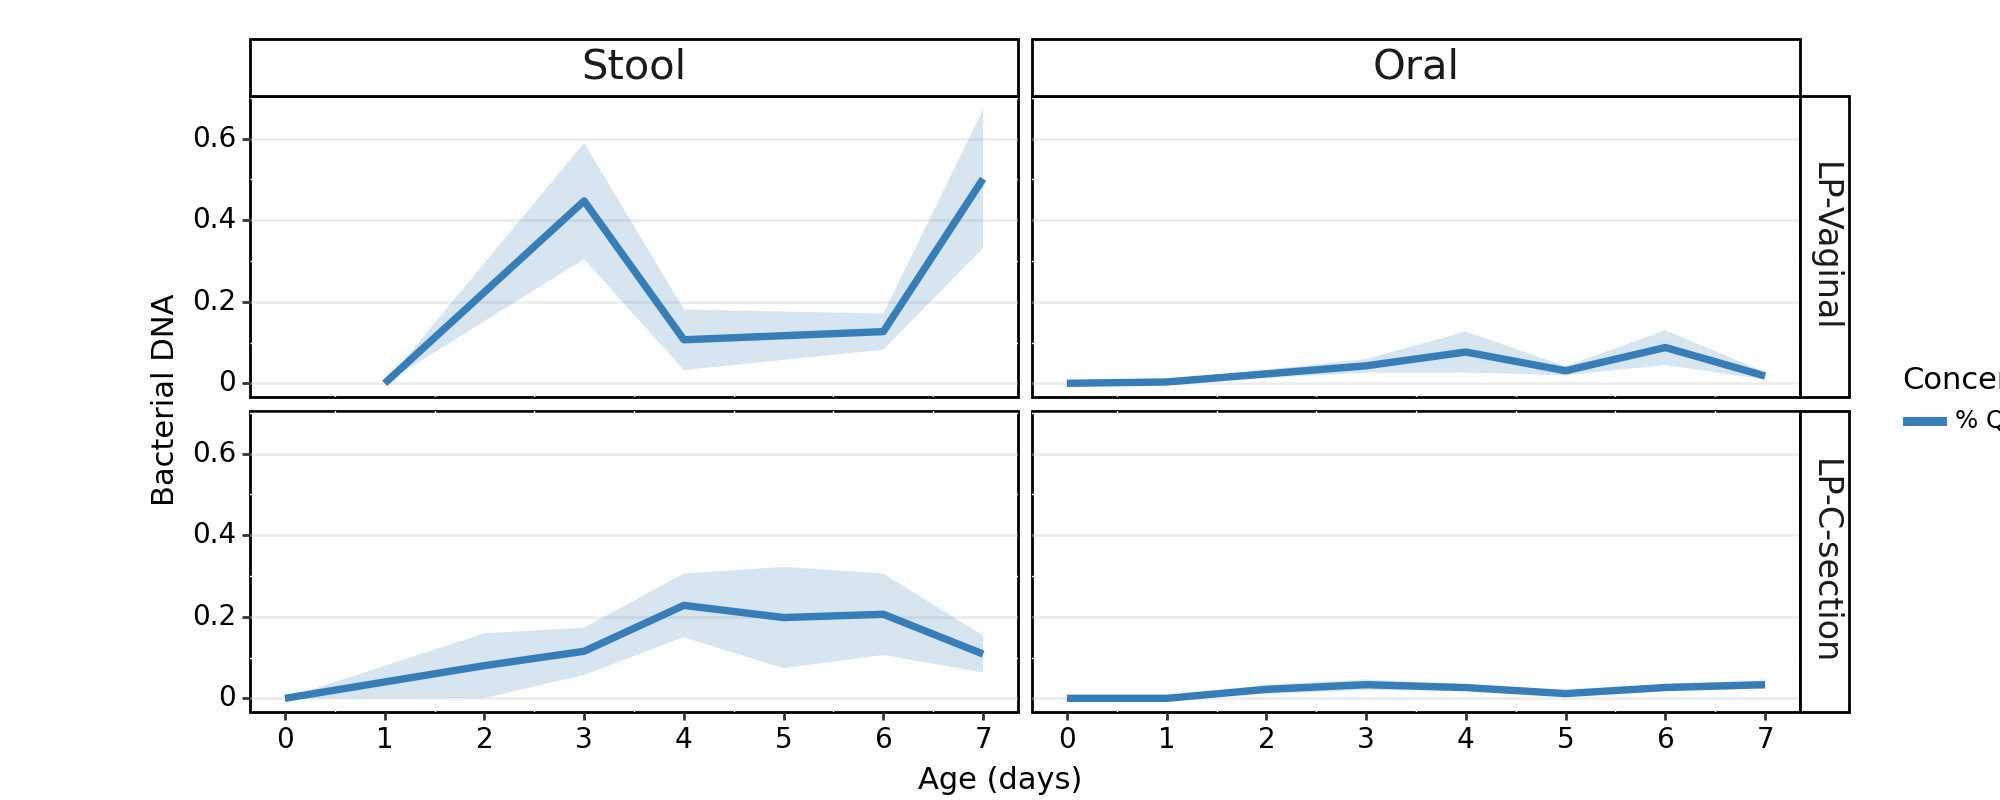

<ggplot: (8744520997310)>

In [128]:
pn.options.figure_size = (10,4)

colors=['#377eb8']

p= (pn.ggplot(data=plot_perc.query('abx_any_source==0')) +
   pn.geom_line(pn.aes(x="age",y="avg", color="variable"), size=1.5) +
    pn.geom_ribbon( pn.aes(x="age", ymax="err_max", ymin="err_min", fill="variable"), alpha=.2) +
    pn.facet_grid("study_delivery_mode~sample_type") +
    pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
    pn.scale_color_manual(colors) +
    pn.scale_fill_manual(colors) +
    pn.guides(fill=None) +
    pn.labs(color="Concentration", y="Bacterial DNA", x="Age (days)") +
    pn.theme(
         panel_background = pn.element_rect(fill="white", color="black"),
         panel_border = pn.element_rect(fill="white", color="black"),
         panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.4),
         panel_grid_major_x = pn.element_blank(),
         strip_text_x = pn.element_text(size=15),
         strip_text_y = pn.element_text(size=12, va="center"),
         legend_key = pn.element_rect(fill="white"),
         axis_text = pn.element_text(color="black",size=10),
         strip_background = pn.element_rect(fill="white",color="black")
     )
   )
#p.save(root_dir + "results/figures/svg/Sourcetracker_metabolomics_abx_NoAbx.svg", dpi=300)
#p.save(root_dir + "results/figures/Sourcetracker_metabolomics_abx_NoAbx.pdf", dpi=300)
p

<IPython.core.display.Javascript object>


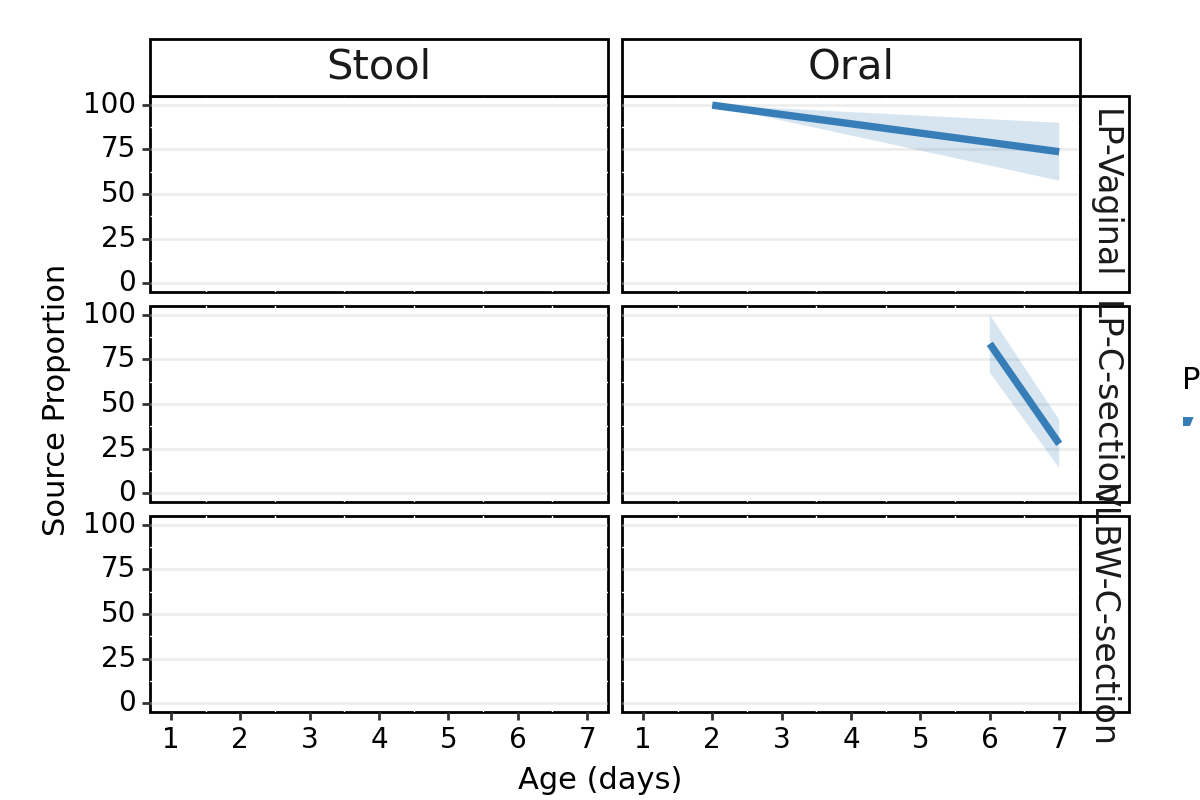

/home/adswafford/.conda/envs/qiime2-2020.11/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/adswafford/.conda/envs/qiime2-2020.11/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/adswafford/.conda/envs/qiime2-2020.11/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


<ggplot: (-9223363292333220450)>

In [21]:
pn.options.figure_size = (10,4)

colors=['#377eb8','#984ea3',  '#4daf4a','#ff7f00', '#f781bf','#999999']

p= (pn.ggplot(data=plot_perc.query('abx_any_source==1')) +
   pn.geom_line(pn.aes(x="age",y="avg", color="variable"), size=1.5) +
    pn.geom_ribbon( pn.aes(x="age", ymax="err_max", ymin="err_min", fill="variable"), alpha=.2) +
    pn.facet_grid("study_delivery_mode~sample_type") +
    pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
    pn.scale_color_manual(colors) +
    pn.scale_fill_manual(colors) +
    pn.guides(fill=None) +
    pn.labs(color="Predicted Source", y="Source Proportion", x="Age (days)") +
    pn.theme(
         panel_background = pn.element_rect(fill="white", color="black"),
         panel_border = pn.element_rect(fill="white", color="black"),
         panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.4),
         panel_grid_major_x = pn.element_blank(),
         strip_text_x = pn.element_text(size=15),
         strip_text_y = pn.element_text(size=12, va="center"),
         legend_key = pn.element_rect(fill="white"),
         axis_text = pn.element_text(color="black",size=10),
         strip_background = pn.element_rect(fill="white",color="black")
     )
   )
#p.save(root_dir + "results/figures/svg/Sourcetracker_metabolomics_abx_NoAbx.svg", dpi=300)
#p.save(root_dir + "results/figures/Sourcetracker_metabolomics_abx_NoAbx.pdf", dpi=300)
p